In [1]:
%%javascript

window.load_remote_theme = true
var theme_js = "https://odhk.github.io/hyrule_theme/custom.js";

window.load_local_theme = function(){
    var hostname = document.location.hostname
    return ((hostname == "localhost" || hostname == '127.0.0.1') && !load_remote_theme)
}

var url = load_local_theme() ? document.location.origin + "/files/theme/custom.js" : theme_js

$.getScript(url)

<IPython.core.display.Javascript object>

In [1]:
# -*- coding: utf-8 -*-
# 导入所需的python库
import time;import datetime
import pandas as pd; import numpy as np
from pandas.tseries.offsets import Hour,Minute,MonthEnd,Day
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data_path = r'D:\比赛数据\360rong'.decode('utf-8').encode('gbk')
title = 'r360'

import os  
mingw_path = 'C:\Program Files\mingw-w64\x86_64-5.3.0-posix-seh-rt_v4-rev0\mingw64\bin'  
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb

In [5]:
def load_data1():
    # user_info# 读取数据集
    user_info_train = pd.read_csv(r'{}\train\user_info_train.txt'.format(data_path), header = None)
    user_info_test = pd.read_csv(r'{}\test\user_info_test.txt'.format(data_path),header = None)
    col_names = ['userid', 'sex', 'occupation', 'education', 'marriage', 'household'] # id 性别 职业,教育程度,婚姻状态,户口类型
    user_info_train.columns = col_names; user_info_test.columns = col_names
    user_info = pd.concat([user_info_train, user_info_test])
    user_info.index = user_info['userid']; user_info.drop('userid',axis = 1,inplace = True)

    # loan_time
    loan_time_train = pd.read_csv(r'{}\train\loan_time_train.txt'.format(data_path),header = None)
    loan_time_test = pd.read_csv(r'{}\test\loan_time_test.txt'.format(data_path), header = None)
    loan_time = pd.concat([loan_time_train, loan_time_test])
    loan_time.columns = ['userid', 'loan_time']
    loan_time = loan_time.set_index('userid')
    loan_time = loan_time.applymap(lambda i:datetime.datetime.fromtimestamp(i))
    
    load_data = user_info.join(loan_time,how='outer')
    return load_data,loan_time

def load_data2():
    # bank_detail
    bank_detail_train = pd.read_csv(r'{}\train\bank_detail_train.txt'.format(data_path), header = None)
    bank_detail_test = pd.read_csv(r'{}\test\bank_detail_test.txt'.format(data_path), header = None)
    col_names = ['userid', 'tm_encode', 'trade_type', 'trade_amount', 'salary_tag']# 用户id，时间戳、交易类型、交易金额、工资收入标记
    bank_detail_train.columns = col_names; bank_detail_test.columns = col_names
    bank_detail = pd.concat([bank_detail_train, bank_detail_test])
#     bank_detail['tm_encode'][bank_detail.tm_encode==0] = bank_detail.tm_encode.median()
    bank_detail['tm_encode'] = bank_detail.tm_encode.map(lambda i:datetime.datetime.fromtimestamp(i))
#     bank_detail['tm_encode'] = [time.strftime("%Y-%m-%d",time.localtime(da)) for da in bank_detail.tm_encode ]
#     print r'银行流水账号：用户id，时间戳、交易类型、交易金额、工资收入标记';print bank_detail.head(5)
    bank_detail = bank_detail.set_index('userid')
    return bank_detail

# 根据贷款时间前60天划分数据
def shaixuan_byTime(load_data,time_name,shift=60): 
    user_info,_ = load_data1()
    load_data = load_data.join(user_info.loan_time)
    loan_data = load_data[load_data[time_name]>(load_data['loan_time']-shift*Day())]
    loan_data = loan_data.drop('loan_time',axis=1)
    return loan_data


In [63]:
# tm_encode	trade_type	trade_amount	salary_tag
def bank_pro(bank_detail):
    bank_detail['tm_date'] = bank_detail.tm_encode.map(lambda i:i.date())
    bank_detail['tm_yearMonth'] = bank_detail.tm_date.map(lambda i:i.strftime('%Y-%m'))
    # trade_amount
    bank_pro = pd.DataFrame([])
    bank_detail = bank_detail.reset_index()
    bank_pro[['bank_income','bank_outcome']] = bank_detail.groupby(['userid','trade_type'])['trade_amount'].sum().unstack()
    bank_pro = bank_pro.fillna(method='ffill',axis=1)
    bank_pro = bank_pro[['bank_outcome','bank_income']].fillna(method='ffill',axis=1)
    bank_pro['bank_outcomeIncomeRate'] = bank_pro.bank_outcome / bank_pro.bank_income
#     bank_pro['bank_salary'] = bank_detail.groupby(['userid','salary_tag']).sum().unstack().iloc[:,1]
#     bank_pro = bank_pro.fillna(0)
#     bank_pro['bank_salaryIncomeRate'] = bank_pro.bank_salary / bank_pro.bank_income
    # trade_amount month
    bank_pro_2 = pd.DataFrame()
    bank_detail = bank_detail_t.reset_index()
    bank_pro_1 = bank_detail.groupby(['userid','tm_yearMonth','trade_type'])['trade_amount'].sum().unstack()
    bank_pro_1.columns = ['income','outcome']
    bank_pro_1[bank_pro_1.outcome==0] = 1 # 防止出现inf
    bank_pro_2['bank_incomeOutcomeRate'] = (bank_pro_1['income'] / bank_pro_1['outcome'])
    bank_pro_2['bank_incomeOutcomePct'] = ((bank_pro_1['income'] - bank_pro_1['outcome'])/ bank_pro_1['outcome']).round(decimals=2)
    bank_pro_2 = bank_pro_2.fillna(bank_pro_2.mean()).round(decimals=2)
    bank_pro['bank_incomeOutcomeRate_monthAvg'] = bank_pro_2.bank_incomeOutcomeRate.mean(level='userid')
    bank_pro['bank_incomeOutcomePct_monthAvg'] = bank_pro_2.bank_incomeOutcomePct.mean(level='userid')
    bank_pro['bank_incomeOutcomeRate_pctSum'] = bank_pro_2.bank_incomeOutcomeRate.unstack().pct_change(axis=1).sum(axis=1)
    bank_pro['bank_incomeOutcomePct_pctSum'] = bank_pro_2.bank_incomeOutcomePct.unstack().pct_change(axis=1).sum(axis=1)
    bank_pro = bank_pro.fillna(0)
    # 支出收入次数统计
    bank_pro_3 = bank_detail[['userid','trade_type','trade_amount']].groupby(['userid','trade_type']).count().unstack()
    bank_pro_3.columns = ['bank_income_count','bank_outcome_count']
    bank_pro = bank_pro.join(bank_pro_3);
    bank_pro[['bank_income_count','bank_outcome_count']] = bank_pro[['bank_income_count','bank_outcome_count']].fillna(0)
    temp = bank_pro[['bank_income_count','bank_outcome_count']]
    temp[temp==0] = 1; temp['bank_outcomeIncome_countRate'] = temp.bank_outcome_count / temp.bank_income_count
    bank_pro['bank_outcomeIncome_countRate'] = temp['bank_outcomeIncome_countRate']
    return bank_pro

In [64]:
bank_detail = load_data2()
# bank_detail_t = shaixuan_byTime(bank_detail,'tm_encode',30)
bank_pro = bank_pro(bank_detail)


C:\Users\Kevin\Anaconda2\lib\site-packages\ipykernel\__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
bank_pro.shape

(10003, 10)

In [108]:
# bill_pro = pd.read_csv('r360_bill_pro_2-4-2.csv',index_col='userid')
# browse_pro = pd.read_csv('r360_browse_pro_2-4-1.csv',index_col='userid')
# user_info,_ = load_data1()

target = pd.read_csv(r'{}\train\overdue_train.txt'.format(data_path), header = None)
target.columns = ['userid', 'label']
target.index = target['userid']
target.drop('userid',axis = 1,inplace = True)

# #/6852
# bill_bank_XT_Index = list(bill_pro.index.intersection(bank_pro.index))
# print r'和信用卡相同的userid个数',(len(bill_bank_XT_Index))
# browse_bank_XT_Index = list(browse_pro.index.intersection(bank_pro.index))
# print r'和浏览记录相同的userid个数',len(browse_bank_XT_Index)
# bill_pro = bill_pro.loc[bill_bank_XT_Index,:]
# browse_pro = browse_pro.loc[browse_bank_XT_Index,:]
# user_info = user_info.loc[bank_pro.index,:]
# load_data = pd.concat([user_info,bill_pro,browse_pro],axis=1)

In [109]:
load_data_1 = load_data.fillna(load_data.mean())
data = load_data_1.join(target)
data = data.drop('loan_time',axis=1)
train = data.loc[:55596,]
test = data.loc[55596:,:].drop('label',axis=1)


Model Report
Accuracy : 0.8535
AUC Score (Train): 0.825872


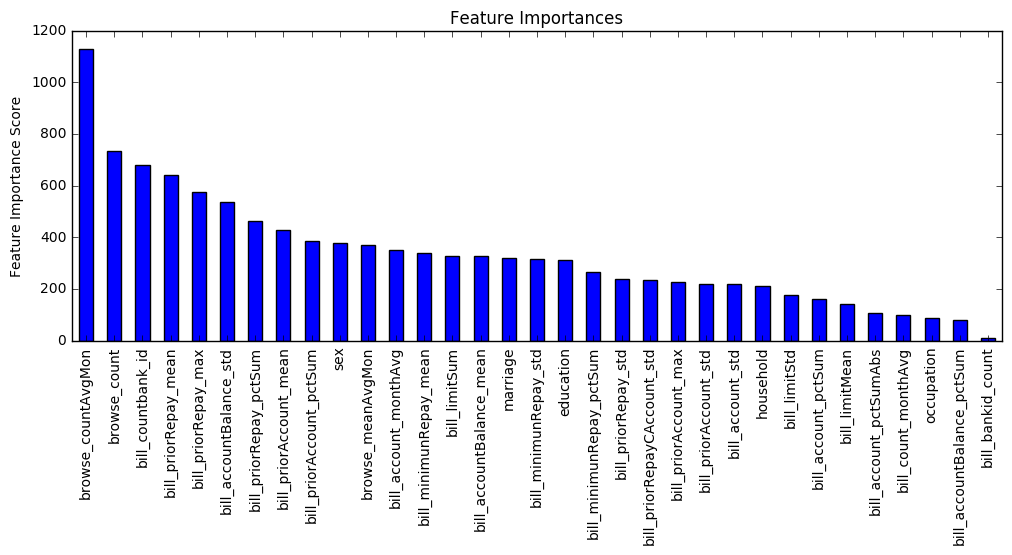

In [110]:
#Import libraries:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

target = 'label'
IDcol = 'ID'
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
#Choose all predictors except target & IDcols
predictors = [i for i in train.columns if i not in [target, IDcol]]
xgb1 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=5,
    gamma=0.2,
    reg_alpha=1e-5,
    subsample=0.8,
    colsample_bytree=0.9,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb1, train, predictors)
xgb1.fit(train[predictors],train[target])
y_prob = xgb1.predict_proba(test)

In [111]:
y_pre_prob = pd.DataFrame(y_prob).iloc[:,1]
y_pre_prob.index = test.index
y_pre_prob = y_pre_prob.reset_index()
y_pre_prob.columns = ['userid','probability']
y_pre_prob.to_csv('result_1_2-5-1.csv',index=False)

In [149]:
# y1 = pd.read_csv('result_2-4-3.csv').set_index('userid')
# y2=y2.set_index('userid')
y3 = y1.loc[y2.index,:]
# y_p = y1
y_p.loc[y2.index,'probability'] = y2.probability
y_p

,probability
userid,
55597,0.112247
55598,0.023943
55599,0.078434
55600,0.151233
55601,0.170722
55602,0.140537
55603,0.186821
55604,0.058184
55605,0.129678


In [150]:
y_p_r = y_p.reset_index()
y_p_r.to_csv('result_2-5-2.csv',index=False)
